# 33150 PSET 1
# Giovanni Longo

## NOTE: ChatGPT was used exclusively for function creation to speed up production time. An example of one of the prompts is as follows: "I have a value within the merged df (i.e. the two columns shared a date when the value was outside the quantile).  I want to take this date (which we will denote by date_n) and find it within the data frame 'TSM_NG_spread_data'. I then want the min(15, end of the data farme) values above and below date_n as well as the value of date_n."

#### Begin by importing necessary libraries and setting varibales.

In [93]:
# %matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import patchworklib as pw
import plotnine as p9
import datetime
import os

quandl.ApiConfig.api_key = '1n-fMYgMqmbySCU-zs6e'

#### We need to create a list of codes that can be fed into the quandl calls, so we have created a function that will generate them automatically from the relevant exchange, future, and option code (decided by student ID 12228450).

In [94]:
def create_code_list(exchange_code, future_code, option_code):
    code_list = []
    for year in range(2020, 2024):
        for quarter in ['H', 'M', 'U', 'Z']:
            expiry_code = quarter + str(year)
            code_list.append(f"OWF/{exchange_code}_{future_code}_{option_code}_{expiry_code}_IVM")
            
    return code_list

#### After we have the codes for the associated pairs, we need to find all the relevant information with the quandl api. The code below will retrieve the data from quandl and use a csv file to convert into a pandas data frame.

In [95]:
def grab_quandl_table(table_path, table_override=False):
    table_dir = 'table_data'
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    my_date = datetime.datetime.now().strftime("%Y%m%d")
    data_file = os.path.join(table_dir, f"{table_path.replace('/', '-')}_{my_date}.csv")
    
    # If the data exists (and we do not want to override), then retrieve it
    if not table_override and os.path.exists(data_file):
        print('Data table found, returning results now...')
        return pd.read_csv(data_file).set_index('Date') 
    
    
    # If no data_file is found or we want to fetch new data, then we must create one in the current directory
    print('No current data table, retrieving data from quandl...')
    data = quandl.get(table_path, start_date='2020-12-03', end_date='2023-08-31')
    quandl_data_codes = table_path[4:].split('_')
    data['Exchange_ID'], data['Future_ID'], data['Option_ID'], data['Expiration_ID'] = quandl_data_codes[:4]
    data.to_csv(data_file)
    print('Data has been saved to ' + data_file)
    return data

def construct_data(code_list, table_override=False):
    df = pd.DataFrame()
    for code in code_list:
        df = pd.concat([df, grab_quandl_table(code, table_override)])
        
    return df

In [96]:
TFM_TFM_code_list = create_code_list('ICE', 'TFM', 'TFM')
NG_NG_code_list = create_code_list('NYM', 'NG', 'NG')
FV_FV_code_list = create_code_list('CBT', 'FV', 'FV')
US_US_code_list = create_code_list('CBT', 'US', 'US')

In [97]:
TFM_TFM_data = construct_data(TFM_TFM_code_list)
NG_NG_data = construct_data(NG_NG_code_list)
FV_FV_data = construct_data(FV_FV_code_list)
US_US_data = construct_data(US_US_code_list)

Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table found, returning results now...
Data table 

#### With our new dataframes, we need to fit the condition that is outlined in the homework (relating to the minimum of the expirations above 30). We have created two helper functions to automate this process.

In [98]:
def min_above_30(group):
    '''
    Finds the minimum contract value above 30 days to adhere to the assignment expectation.
    '''
    filtered_group = group[group['DtT'] > 30]
    if not filtered_group.empty:
        return filtered_group.loc[filtered_group['DtT'].idxmin()]
    else:
        return pd.Series()

def process_data(futures_dataframe):
    '''
    Automate the process of returning the correct future contracts for the given dates.
    '''
    df = futures_dataframe.reset_index()
    df = df.groupby('Date').apply(min_above_30).drop(['Date'], axis=1)
    return df

In [99]:
processed_TSM_data = process_data(TFM_TFM_data)
processed_NG_data = process_data(NG_NG_data)
processed_FV_data = process_data(FV_FV_data)
processed_US_data = process_data(US_US_data)

#### After we have data that is correctly grouped and filtered by the lowest time to expiration, we need to create data frames of the futures spreads (with the expected multiplication shifts).

In [100]:
TSM_NG_spread_data = (processed_NG_data['Future']*13.7261 - processed_TSM_data['Future']).to_frame().rename(columns={'Future':'TSM_NG_Future'})
FV_US_spread_data = (processed_US_data['Future']*0.7595 - processed_FV_data['Future']).to_frame().rename(columns={'Future':'FV_US_Future'})

In [101]:
if 'Date' not in TSM_NG_spread_data.columns:
    TSM_NG_spread_data = TSM_NG_spread_data.reset_index()
    TSM_NG_spread_data['Date'] = pd.to_datetime(TSM_NG_spread_data['Date'])
    
if 'Date' not in FV_US_spread_data.columns:
    FV_US_spread_data = FV_US_spread_data.reset_index()
    FV_US_spread_data['Date'] = pd.to_datetime(FV_US_spread_data['Date'])


TSM_NG_spread_plot = pw.load_ggplot(
    (p9.ggplot(TSM_NG_spread_data, p9.aes(x='Date', y='TSM_NG_Future')) 
    + p9.geom_line() 
    + p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1), plot_title=p9.element_text(ha='center'))
    + p9.ggtitle("NG (times 13.7261) vs. TSM Future Spread")
    + p9.labs(x="Date", y="Future Spread Value")), figsize=(5,3))

FV_US_spread_plot = pw.load_ggplot(
    (p9.ggplot(FV_US_spread_data, p9.aes(x='Date', y='FV_US_Future')) 
    + p9.geom_line() 
    + p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1), plot_title=p9.element_text(ha='center'))
    + p9.ggtitle("US (times 0.7595) vs. FV Future Spread")
    + p9.labs(x="Date", y="Future Spread Value")), figsize=(5,3))

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


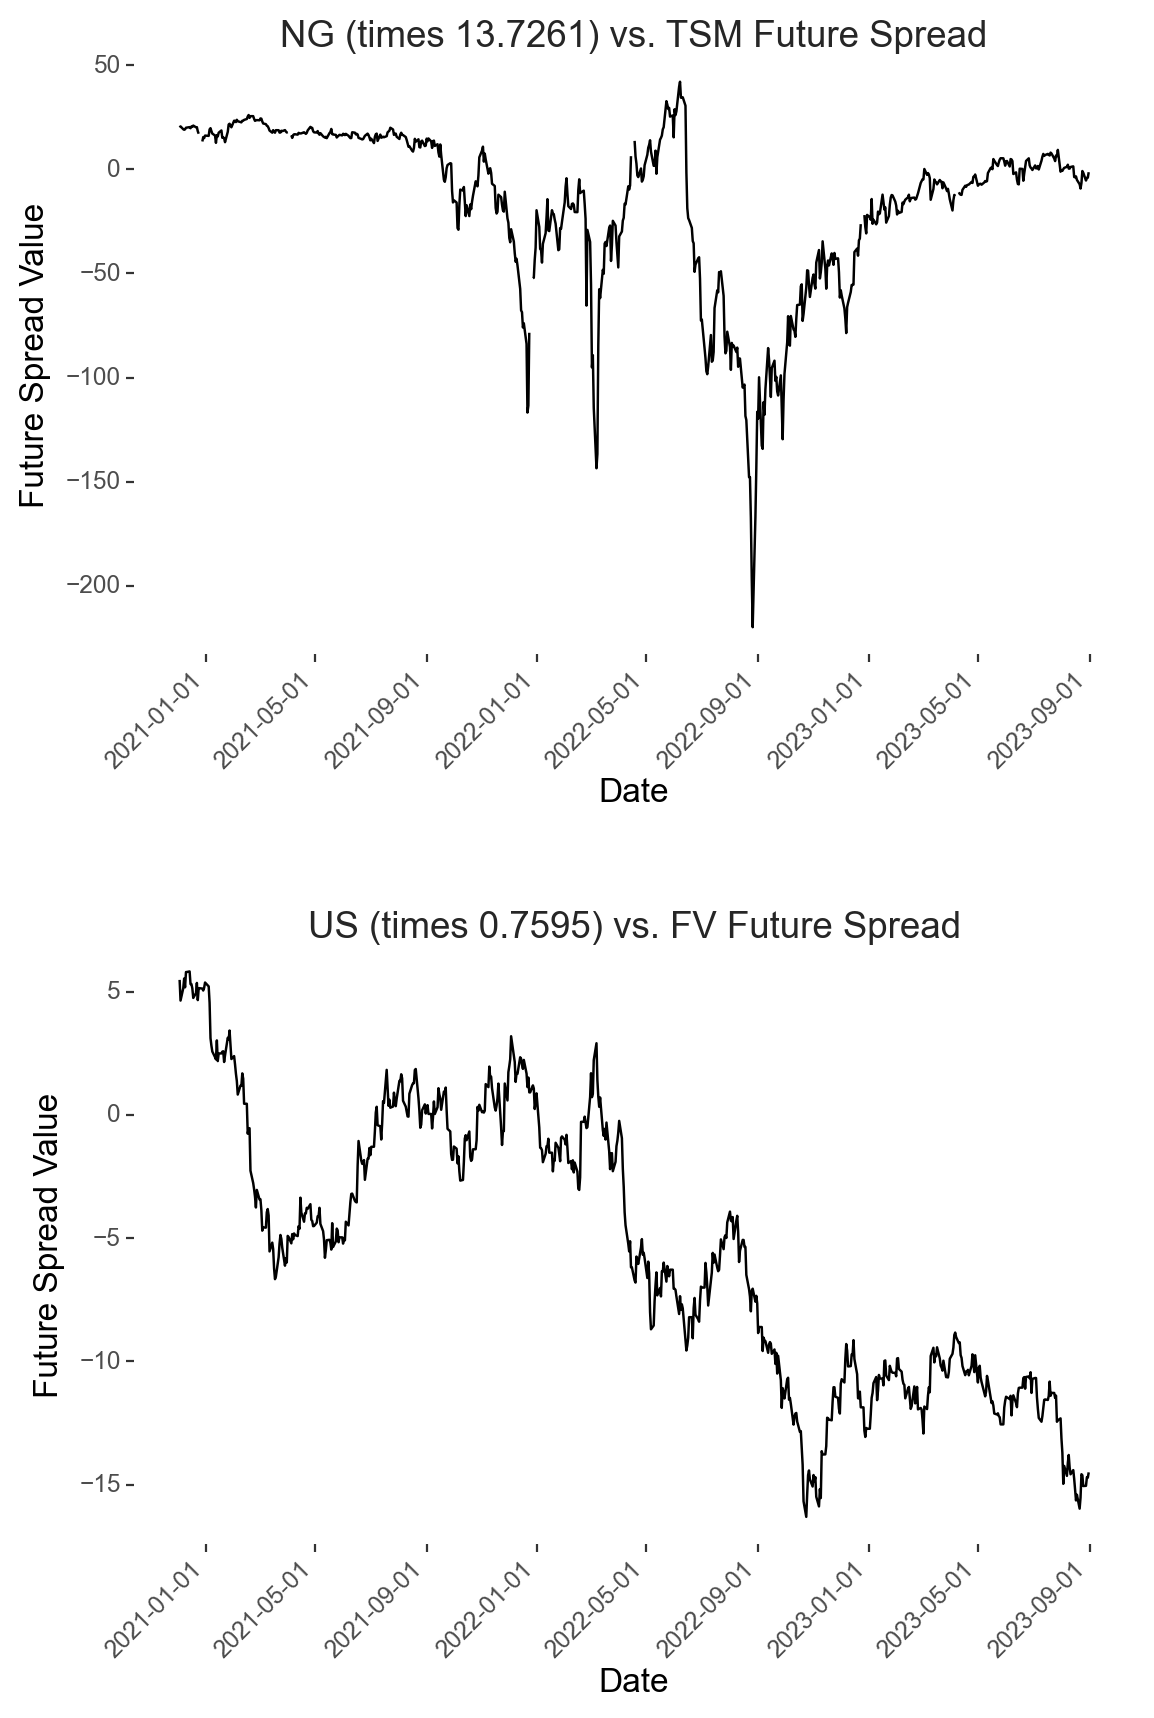

In [102]:
# Using the patchwork library, we have stacked the two spread graphs on top of each other
TSM_NG_spread_plot/FV_US_spread_plot

#### After looking at the two graphs visually, we can see that they appear to move in tandem during certain periods (i.e. we should expect some correlation between the spreads). We will test this using the correlation function for pandas. Additionally, we will graph both future spreads onto one graph for visual aid.

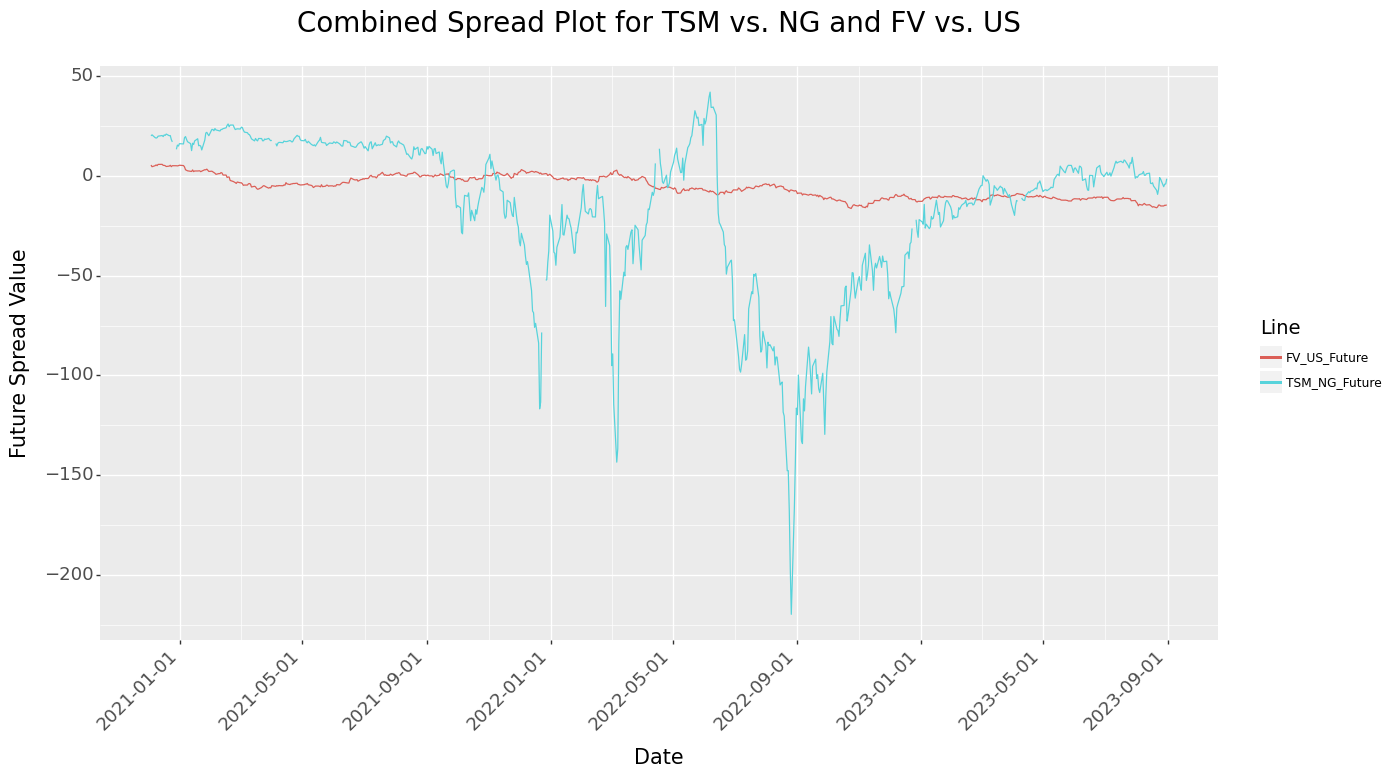

<Figure Size: (1400 x 800)>

In [103]:
combined_spread_df = pd.concat([TSM_NG_spread_data, FV_US_spread_data.FV_US_Future.to_frame()], axis=1)
melted_spread_df = combined_spread_df.melt(id_vars='Date', var_name='Line', value_name='Value')

combined_spread_plot = (
    p9.ggplot(melted_spread_df, p9.aes(x='Date', y='Value', color='Line')) 
    + p9.geom_line()
    + p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1, size=13),
               axis_text_y=p9.element_text(size=13),
               axis_title_x=p9.element_text(size=15),                     # X-axis title
               axis_title_y=p9.element_text(size=15), 
               plot_title=p9.element_text(size=20, ha='center'),
               legend_title=p9.element_text(size=14),
               figure_size=(14,8))
    + p9.ggtitle("Combined Spread Plot for TSM vs. NG and FV vs. US")
    + p9.labs(x="Date", y="Future Spread Value")
)

combined_spread_plot

#### When looking at the two graphs overlaid with each other, we see that they do not follow as closely as they looked on their own. Let us test with an actual correlation statistic to confirm.

In [104]:
spread_correlation = TSM_NG_spread_data['TSM_NG_Future'].corr(FV_US_spread_data['FV_US_Future'])
spread_correlation

0.21721162102391625

#### This correlation is low, which at least indicates over the sample period that TSM vs. NG and FV vs. US futures spreads were not highly correlated. Another interesting consideration for the spread data is to see if there's an alignment of outliers by date. So, we should first examine where the spread outliers (top and bottom x%) occur in each data frame and see if the corresponding dates match. 

In [105]:
def filter_df_by_quantile_bounds(df, column, tail_size=0.05):
    """
    Filter a DataFrame to only include rows where the specified column's values
    fall within the upper and lower tail quantiles.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    lower_quantile = df[column].quantile(tail_size)
    upper_quantile = df[column].quantile(1 - tail_size)

    filtered_df = df[(df[column] <= lower_quantile) | (df[column] >= upper_quantile)]

    return filtered_df.set_index('Date')

In [106]:
quantile_TSM_NG_df = filter_df_by_quantile_bounds(TSM_NG_spread_data, 'TSM_NG_Future')
quantile_FV_US_df = filter_df_by_quantile_bounds(FV_US_spread_data, 'FV_US_Future')

merged_quantile_df = pd.merge(quantile_TSM_NG_df, quantile_FV_US_df, left_index=True, right_index=True, how='inner')
display(merged_quantile_df)

,TSM_NG_Future,FV_US_Future
Date,,
2022-03-07,-143.532384,2.908547


#### Interestingly, there is a period of time in which both spread data sets share a date where the spread value is outside the 5% quantile range. If we look closely, however, we see that TSM vs. NG value is from the lower quantile and the FV vs. US value is from the upper quantile. Even in this case, let us take the 15 days on either side of this date and see if we have a stronger absolute correlation between the spreads.

In [107]:
def extract_date_window(df, date_n, window_size=15):
    """
    Extracts a window of values around a specified date from a DataFrame.
    """
    date_pos = df.index.get_loc(date_n)

    start_pos = max(0, date_pos - window_size)
    end_pos = min(len(df), date_pos + window_size + 1)

    extracted_df = df.iloc[start_pos:end_pos]

    return extracted_df

In [108]:
match_date = merged_quantile_df.index[0]

extracted_TSM_NG_df = extract_date_window(TSM_NG_spread_data.set_index('Date'), match_date)
extracted_FV_US_df = extract_date_window(FV_US_spread_data.set_index('Date'), match_date)

extracted_spread_correlation = extracted_TSM_NG_df['TSM_NG_Future'].corr(extracted_FV_US_df['FV_US_Future'])
extracted_spread_correlation

-0.7881400117867479

#### Now this looks much better! Even though we saw that the entire data frame was not highly correlated, we now see that there was a specific time frame in which the two spreads had a high negative correlation. This also makes sense because one of the outliers came from the upper quantile and the other from the lower quantile. These dates were discovered through the outliers within the spread data, so they are not randomly chosen and could indicate a potential area of interest to explore. We would need to look at other surrounding data and market conditions during this time frame to formulate a strategy idea, but this is a starting point to finding a potential PnL opportunity.

## We have characterized the dynamics of the two sets of spreads by the correlation of their spread values in a period of outlier similarity. This is NOT a strategy in itself, but this information gives a useful launch point for future data analysis. Potential branching exploration could look into other spread correlations during this time to see if there was a general market correlation or if we have actually found an interesting pair to backtest in other periods. Another avenue would be to characterize the overall market dynamics of future spreads to apply to out of sample strategies in the case that we saw a general market trend, and if no such trend existed, then we could see if there were other pockets of correlations for the two analyzed spreads in different periods of time.